# Results - Eligible CIViC variants for the CIViC smMIPs capture panel

## Tools 

In [1]:
#!/usr/bin/env python3
import json
import numpy as np
import requests
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')
sns.set_context("poster")

# Pull in Input Files

In [2]:
##Pull in CIViC Data from JSON
variants_DNA = requests.get('https://civic.genome.wustl.edu/api/panels/DNA-based/qualifying_variants?minimum_score=0').json()['records'] #Call eligible variants

In [3]:
##Pull in smMIPs Final Design
smmips_design_final = pd.read_csv('../data/smmips_panel/final_civic_smmips_with_removed.txt', sep='\t')

In [4]:
##Pull in Failed Variants
failed = pd.read_csv('../data/smmips_panel/failed_probes.txt', sep='\t')

# Evaluate smMIPs Panel

In [5]:
print('Length of Initial CIViC Probes Design: ', len(smmips_design_final) + len(failed))
print('Total Number of Failed Probes: ', len(failed))
print('Length of Final CIViC Probes Design: ', len(smmips_design_final))

Length of Initial CIViC Probes Design:  2097
Total Number of Failed Probes:  70
Length of Final CIViC Probes Design:  2027


In [6]:
##Determine total variants and genes in final panel
genes = []
variants = []
for item in smmips_design_final['mip_name'].drop_duplicates():
    gene = item.split('_')[0]
    if gene not in genes:
        genes.append(gene)
    for variant in item.split('_')[1:-1]:
        if variant == 'N131P (c.390':
            variants.append([gene, 'N131P (c.390_391delTA)'])
        elif variant == '391delTA)':
            continue
        else:
            variants.append([gene, variant])

# Evaluate Failed Probes

In [7]:
##Determine total variants and genes in final panel
genes_failed = []
variants_failed = []
for item in failed['mip name'].drop_duplicates():
    gene = item.split('_')[0]
    if gene not in genes_failed:
        genes_failed.append(gene)
    for variant in item.split('_')[1:-1]:
        if variant == 'N131P (c.390':
            variants_failed.append([gene, 'N131P (c.390_391delTA)'])
        elif variant == '391delTA)':
            continue
        else:
            variants_failed.append([gene, variant])

In [8]:
print('Variants affected by failed probes: ', len(pd.DataFrame(variants_failed).drop_duplicates()))

Variants affected by failed probes:  32


In [9]:
print( 'Genes affected by failed probes: ', len(genes_failed))

Genes affected by failed probes:  16


# Final Genes and Variants in Panel

In [10]:
print('Total Number of Variants in Panel: ', len(pd.DataFrame(variants).drop_duplicates()))
print('Total Number of Genes in Panel: ', len(genes))

Total Number of Variants in Panel:  111
Total Number of Genes in Panel:  65


# Determine Buckets for Evaluation

In [11]:
bucket_directory = {}
variants_df = pd.DataFrame(variants).drop_duplicates()
variants_df.columns = ['gene', 'variant']
for i,row in variants_df.iterrows():
    gene = row['gene']
    variant = row['variant']
    code = str(gene + '_' + variant)
    
    for item in variants_DNA:
        civic_gene = item['entrez_name']
        civic_variant = item['name']
        if gene == civic_gene and variant == civic_variant:
            start = item['coordinates']['start']
            stop = item['coordinates']['stop']
            length = stop - start
            if length <= 200:
                bucket_directory[code] = 'hotspot_targeting'
            if length > 200:
                if civic_variant == 'AMPLIFICATION' or civic_variant == 'LOSS' or civic_variant == 'DNA BINDING DOMAIN MUTATION':
                    bucket_directory[code] = 'sparse_tiling'
                else:
                    bucket_directory[code] = 'full_tiling'
                

In [12]:
buckets = pd.DataFrame.from_dict(bucket_directory, orient='index').reset_index()
buckets.columns = ['gene_variant', 'bucket']

In [13]:
print('Total Number of Variants in Panel: ', len(pd.DataFrame(variants).drop_duplicates()))
print()
for i,item in pd.DataFrame(buckets.groupby('bucket').size()).iterrows():
    print('Number of variants requiring', i, ':',item[0])

Total Number of Variants in Panel:  111

Number of variants requiring full_tiling : 26
Number of variants requiring hotspot_targeting : 71
Number of variants requiring sparse_tiling : 14


# Determine Clinical Information

In [14]:
clinical_directory = {}
variants_df = pd.DataFrame(variants).drop_duplicates()
variants_df.columns = ['gene', 'variant']
for i,row in variants_df.iterrows():
    gene = row['gene']
    variant = row['variant']
    code = str(gene + '_' + variant)
    clinical_directory[code] = [0,0,0,0]
    for item in variants_DNA:
        civic_gene = item['entrez_name']
        civic_variant = item['name']
        
        if gene == civic_gene and variant == civic_variant:
            for evidence_item in item['evidence_items']:
                if evidence_item['evidence_type'] == 'Predictive':
                    clinical_directory[code][0] += 1
                if evidence_item['evidence_type'] == 'Prognostic':
                    clinical_directory[code][1] += 1
                if evidence_item['evidence_type'] == 'Diagnostic':
                    clinical_directory[code][2] += 1
                if evidence_item['evidence_type'] == 'Predisposing':
                    clinical_directory[code][3] += 1

In [15]:
smmips_evidence_items = pd.DataFrame.from_dict(clinical_directory, orient='index')                       
smmips_evidence_items.columns=['Predictive', 'Prognostic', 'Diagnostic', 'Predisposing']
print('Total Number of Evidence Items: ', smmips_evidence_items.sum().sum(), '\n')
print(smmips_evidence_items.sum(), '\n')
print(smmips_evidence_items.sum()/smmips_evidence_items.sum().sum() * 100, '\n')

Total Number of Evidence Items:  1168 

Predictive      820
Prognostic      232
Diagnostic       52
Predisposing     64
dtype: int64 

Predictive      70.205479
Prognostic      19.863014
Diagnostic       4.452055
Predisposing     5.479452
dtype: float64 



In [16]:
smmips_evidence_items_merged = smmips_evidence_items.reset_index()
smmips_evidence_items_merged.columns = ['gene_variant','Predictive','Prognostic','Diagnostic','Predisposing']
smmips_evidence_items_merged = smmips_evidence_items_merged.merge(buckets, on='gene_variant')

In [17]:
bucket = smmips_evidence_items_merged.groupby(['bucket']).sum().reset_index()

In [18]:
bucket.melt(id_vars='bucket')

,bucket,variable,value
0,full_tiling,Predictive,117
1,hotspot_targeting,Predictive,551
2,sparse_tiling,Predictive,152
3,full_tiling,Prognostic,67
4,hotspot_targeting,Prognostic,149
5,sparse_tiling,Prognostic,16
6,full_tiling,Diagnostic,4
7,hotspot_targeting,Diagnostic,48
8,sparse_tiling,Diagnostic,0
9,full_tiling,Predisposing,0


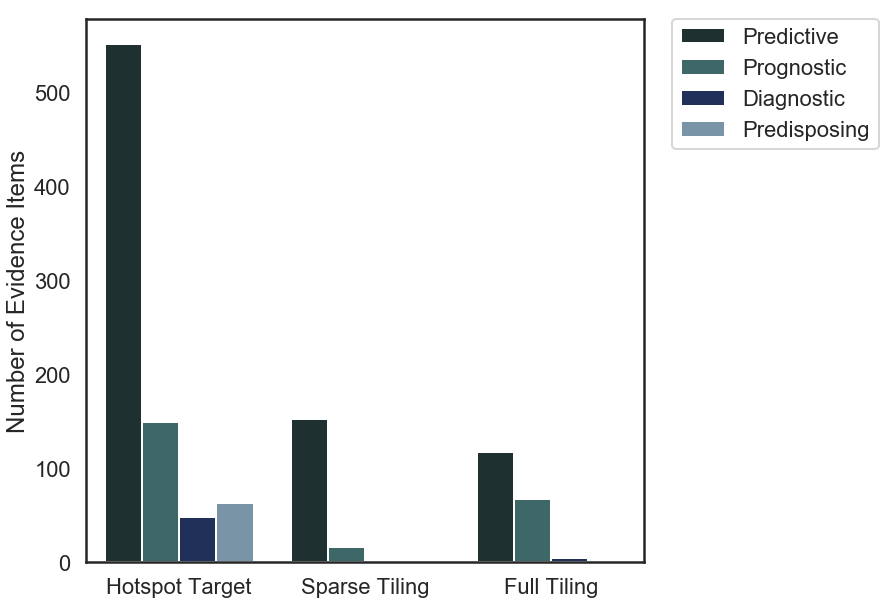

In [19]:
#Create Figure 1
palette ={"Predictive":"#1C3334","Prognostic":"#376E6F","Diagnostic":"#182C61","Predisposing":"#7395AE"}

plt.figure(figsize=(10,10))
sns.barplot(data=bucket.melt(id_vars='bucket'), x='bucket',y='value', 
            hue='variable', 
            order=('hotspot_targeting', 'sparse_tiling', 'full_tiling'),
            palette=palette).set(
    xlabel='', 
    ylabel='Number of Evidence Items', 
    xticklabels=['Hotspot Target', 'Sparse Tiling', 'Full Tiling'])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('../data/Figures/smMIPs_Distribution.pdf', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

# Evaluate Total CIViC Variants Covered by CIViC Panel

In [20]:
bed_smmips = pd.read_csv('../data/smmips_panel/smmips_coordinates_sorted_merged.bed.txt', sep='\t', header=None)
bed_smmips.columns = ['chr', 'start', 'stop']
bed_smmips['start'] = pd.to_numeric(bed_smmips['start'])
bed_smmips['stop'] = pd.to_numeric(bed_smmips['stop'])
bed_smmips['chr'] = bed_smmips['chr'].astype(str)

In [21]:
length_bed = 0
for i,row in bed_smmips.iterrows():
    if row['stop'] - row['start'] < 200:
        length_bed += row['stop'] - row['start']
    else:
        length_bed += 110
print('Length of panel: ', length_bed/1000, 'kb')

Length of panel:  61.544 kb


In [22]:
genes_all = []
variants_all = []
for item in variants_DNA:
    chrom = str(item['coordinates']['chromosome'])
    start = int(item['coordinates']['start'])
    stop = int(item['coordinates']['stop'])
    for i,row in bed_smmips.iterrows():
        if chrom == row[0] and start > row[1] and stop < row[2]:
            gene = item['entrez_name']
            variant = item['entrez_name'] + '_' + item['name']
            if gene not in genes_all:
                genes_all.append(gene)
            if variant not in variants_all:
                variants_all.append(variant)

In [23]:
print('Variants Regardless of Actionability Score:' + '\t' + '\n')
print('Total Number of Genes in Panel: ', len(genes_all))
print('Total Number of Variants in Panel: ', len(pd.DataFrame(variants_all).drop_duplicates()))

Variants Regardless of Actionability Score:	

Total Number of Genes in Panel:  49
Total Number of Variants in Panel:  407


In [24]:
variants_all_df = pd.DataFrame(variants_all)
variants_all = []
for i,item in variants_all_df.iterrows():
    gene = item[0].split('_')[0]
    variant = item[0].split('_')[1:]
    variants_all.append([gene, variant])

In [25]:
variants_all_df = pd.DataFrame(variants_all)
variants_all_df.columns = ['gene', 'variant']

In [26]:
variants_all_df.groupby('gene').size()

gene
ABCB1       1
ABL1        7
AKT1        1
ALK        14
ASXL1       1
ATM         2
BRAF       24
BRCA1       1
BRCA2       1
BTK         1
CALR        1
CDK4        1
CTNNB1      3
DNMT3A      1
DPYD        2
EGFR       23
ERBB2       7
ERCC2       1
EZH2        1
FCGR2A      1
FCGR3A      1
FGFR2       1
FLT3        7
GNAS        1
HOXB13      1
IDH1        5
IDH2        3
JAK2        1
KIT        15
KRAS       17
MAP2K7      1
MET         1
MTHFR       1
MYD88       1
NOTCH1      5
NPM1        2
NRAS        7
NT5C2       2
PDGFRA      8
PIK3CA      7
PTEN        4
RET         1
ROS1        3
TP53       10
U2AF1       2
UGT1A1      1
VHL       203
WT1         1
XRCC1       1
dtype: int64